This notebook will be used to show a proof-of-concept of using Twitter data to extract overall market sentiments and use them to predict direction of overall market (SPY)

## Setup - Do once (Only in Colab)

In [2]:
try:
    import google.colab
    IN_COLAB = True
    
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir('/content/drive/My Drive/Colab Notebooks/RoboAdvisor')
    print('Working directory changed to ' + os.getcwd())  

except:
    IN_COLAB = False




In [3]:
if IN_COLAB:
    !pip install nltk
    import nltk
    nltk.download('vader_lexicon')

## Calculate Sentiments for Tweets

In [18]:
import pandas as pd
import re
single_digit_hour = re.compile(r'\b(\d{1}):([0-5]?[0-9])')

# Tweets obtained via "Twitter-Get-Old-Tweets-Scraper-master" from github (https://github.com/PJHRobles/Twitter-Get-Old-Tweets-Scraper), with some bug-fixes by arruda
username="cnbc"
twitter_data = '../data/twitter/tweets_'+username+'.csv'
dataset = pd.read_csv(twitter_data)

# dataset = dataset.drop_duplicates(["permalink"])
# dataset.to_csv(twitter_data, index=False)

dataset = dataset.drop(['language', 'tweet_id', 'permalink', 'user_handle'], axis=1)

# zero-pad hour in date string, then convert to a datetime
dataset['date'] = [re.sub(single_digit_hour, lambda s: '{}:{}'.format(s.group(1).zfill(2), s.group(2)), str(x)) for x in dataset['date']]
dataset['date'] = pd.to_datetime(dataset['date'], format="%d/%m/%Y %H:%M")

dataset['geological_location'] = dataset['geological_location'].fillna('N/A')
# dataset['mentions'] = dataset['mentions'].fillna('')
# dataset['hashtags'] = dataset['hashtags'].fillna('')
dataset.head()

,username,date,retweets,favorites,text,geological_location,mentions,hashtags
0,CNBC,2020-04-05 23:12:00,86,170,Top U.S. toilet paper maker: 'We're working ar...,N/A,@CNBCMakeIt,NaN
1,CNBC,2020-04-05 22:04:00,15,43,"Sometimes, the best thing to do is nothing. An...",N/A,@danariely @acorns,#investinyou
2,CNBC,2020-04-05 14:39:00,198,483,Bill Gates calls coronavirus pandemic a 'night...,N/A,NaN,NaN
3,CNBC,2020-04-04 15:44:00,281,1051,"China is donating 1,000 ventilators to help Ne...",N/A,NaN,NaN
4,CNBC,2020-04-04 14:44:00,49,149,Bank of America says the lows for stock prices...,N/A,NaN,NaN


In [22]:
# print(dataset.isnull().sum())
print(dataset.info())
print()
print("Total rows:", len(dataset))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58529 entries, 0 to 58528
Data columns (total 9 columns):
username               58529 non-null object
date                   58529 non-null datetime64[ns]
retweets               58529 non-null int64
favorites              58529 non-null int64
text                   58529 non-null object
geological_location    58529 non-null object
mentions               11929 non-null object
hashtags               1874 non-null object
finBERT                58513 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 4.0+ MB
None

Total rows: 58529


### Perform preprocessing of tweets

In [4]:
pat1 = r'@[A-Za-z0-9]+' # this is to remove any text with @....
pat2 = r'^https?:\/\/.*[\r\n]*'
# pat2 = r'https?://[A-Za-z0-9./]+'  # this is to remove the urls
combined_pat = r'|'.join((pat1, pat2)) 
pat3 = r'[^a-zA-Z]' # to remove every other character except a-z & A-Z
combined_pat2 = r'|'.join((combined_pat,pat3)) # we combine pat1, pat2 and pat3 to pass it in the cleaning steps

# import re
# import nltk
# cleaned_tweets = []

# Typical preprocessing will perform lowercasing, Stemming/Lemmatization and stopwords removal 
# BUT for sentiments, letter case is important
# Stemming/lemmatization also does not seem to be required
# Stopwords should not be removed as they might change the meaning of the words/sentences
# so we will just remove mentions (@) and urls
# for i in range(0, len(dataset['text'])) :
#     tweets = re.sub(combined_pat2,' ',dataset['text'][i])
#     cleaned_tweets.append(tweets)

### Try using VADER for sentiment analysis
VADER (Valence Aware Dictionary and sEntiment Reasoner) which is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media
(read more here: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f)

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# for tweet in dataset['text'][:10]:
#     print(tweet)
#     s = sia.polarity_scores(tweet)
#     for k in sorted(s):
#         print('{0}: {1}, '.format(k, s[k]), end='')
#     print("\n")
    
sentiment = []
for tweet in dataset['text']:
    s = sia.polarity_scores(tweet)
    sentiment.append(s['compound'])

dataset['vader'] = sentiment
dataset[['text','vader']][:15]

,text,vader
0,Billionaires including Jeff Bezos and Elon Mus...,-0.5106
1,"We saw 3 market moves we've never seen before,...",0.0516
2,Twitter reached a deal with investment firms E...,0.1027
3,Italy extends its quarantine to the entire cou...,0.1280
4,NYC Mayor urges New Yorkers to work from home ...,0.0000
5,Prince Andrew refuses to cooperate in Jeffrey ...,0.0000
6,"Robinhood goes down again, causing customers t...",-0.1531
7,"BREAKING: The Dow falls 2,000 points, the S&P ...",0.0000
8,BREAKING: Trading halted for 15 minutes as the...,0.0000
9,"BREAKING: The Dow opens down more than 1,700 p...",0.0000


In [4]:
dataset[dataset['vader']==0]['text']

4        NYC Mayor urges New Yorkers to work from home ...
5        Prince Andrew refuses to cooperate in Jeffrey ...
7        BREAKING: The Dow falls 2,000 points, the S&P ...
8        BREAKING: Trading halted for 15 minutes as the...
9        BREAKING: The Dow opens down more than 1,700 p...
15       Amtrak suspends nonstop Acela service between ...
16       The U.S. added 273,000 jobs in February, smash...
18       Quest Diagnostics will start testing for the c...
23       Taxis in France are taking flight. Check out t...
24       Trading halted for 15 minutes this morning aft...
25       Robinhood is experiencing another major outage...
30       Here's a look at the biggest S&P 500 1-day dro...
31       What does a halt in trading at the NYSE mean? ...
33       Over $21 billion wiped off cryptocurrency mark...
35       Blast from the past.  Watch Elon Musk predict ...
36       Take a look at Singapore Airlines' hotel rooms...
38       GOP congressman wields AR-15, dares Joe Biden .

Vader failed to capture 'clear' negative sentiments for the above, and regarded them as neutral, so while it is supposed to be suitable for social media, it is unfortunately not good enough for finance related tweets.

### Try using FinBert for Sentiment Analysis
FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification
See https://arxiv.org/pdf/1908.10063.pdf @ https://github.com/ProsusAI/finBERT

In [5]:
import sys
sys.path.append('..')  # add parent folder to sys path

from models.finbert.finbert import predict
from pytorch_pretrained_bert.modeling import BertForSequenceClassification
from pathlib import Path
import os

model_path = "../models/finbert/classifier_model/finbert-sentiment"
output_dir = "output/"
output = username+'_predictions.csv'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

text = dataset['text'].tolist()
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3, cache_dir=None)

04/06/2020 15:01:52 - INFO - pytorch_pretrained_bert.modeling -   loading archive file ../models/finbert/classifier_model/finbert-sentiment
04/06/2020 15:01:52 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [6]:
import logging
logging.disable(logging.INFO)
predict(text[0:20], model, write_to_csv=False, path='')

,logit,prediction,sentence,sentiment_score
0,"[0.16809931, 0.04032179, 0.79157895]",neutral,Top U.S. toilet paper maker: 'We're working ar...,0.127778
1,"[0.059176937, 0.07071336, 0.87010974]",neutral,"Sometimes, the best thing to do is nothing. An...",-0.011536
2,"[0.06034612, 0.79981655, 0.1398373]",negative,Bill Gates calls coronavirus pandemic a 'night...,-0.739470
3,"[0.65577793, 0.024933798, 0.31928828]",positive,"China is donating 1,000 ventilators to help Ne...",0.630844
4,"[0.040955614, 0.7305883, 0.22845607]",negative,Bank of America says the lows for stock prices...,-0.689633
5,"[0.022757439, 0.94905156, 0.028190918]",negative,Tesla is dismissing contractors at its Califor...,-0.926294
6,"[0.06892389, 0.05432731, 0.8767488]",neutral,Working from home is now mainstream. But is it...,0.014597
7,"[0.27062473, 0.030174866, 0.6992004]",neutral,The UK just built the world's largest critical...,0.240450
8,"[0.8188184, 0.019040503, 0.16214108]",positive,Bank of America's small business loan portal i...,0.799778
9,"[0.4445097, 0.5133864, 0.042103805]",negative,JUST IN: U.S. weekly jobless claims surge to m...,-0.068877


With FinBERT, sentiment scores now reflect actual sentiments much better!

In [20]:
# Remember to set to False after first run otherwise it will take a long time to predict all predictions again!
toRun = False

output_dir = "../data/twitter"
# output = 'sentiments_overall.csv'
output = username+'_sentiments_overall.csv'
output_fullpath = os.path.join(output_dir, output)

if toRun:    
    if not os.path.exists(output_dir):
        print("Ouput directory does not exist @ " + output_dir)
    else:
        results = predict(text, model, write_to_csv=True, path=output_fullpath)
        results.insert(0, 'date', dataset['date'])
        
        results = results.drop_duplicates(["sentence"])
        results.to_csv(output_fullpath, index=False, float_format="%.7g")
else:
    results = pd.read_csv(output_fullpath) 
    
dataset['finBERT'] = results['sentiment_score']

In [8]:
results.tail()

,date,logit,prediction,sentence,sentiment_score
1566,2020-03-10 05:06:00,"[0.29368111, 0.04635591, 0.659963]",neutral,Chinese President Xi Jinping visits Wuhan for ...,0.247325
1567,2020-03-10 04:02:00,"[0.07737292, 0.18267383, 0.7399532]",neutral,Elon Musk on planning for Mars: 'The city has ...,-0.105301
1568,2020-03-10 03:40:00,"[0.62272125, 0.01858134, 0.35869738]",positive,"Solar power is booming, and it could help lead...",0.604140
1569,2020-03-10 03:00:00,"[0.076763816, 0.03457523, 0.888661]",neutral,Apple says it’s now OK to use disinfectant wip...,0.042189
1570,2020-03-10 02:14:00,"[0.03613412, 0.88914365, 0.07472223]",negative,All but four of Apple's stores in mainland Chi...,-0.853010


In [48]:
# dataset.sort_values(['date'], ascending=True)

In [30]:
# we need to convert the sentiments to the correct timezone
# in our case, we will be looking at the US stockmarket (NYSE). Therefore, timezone is UTC-5
dataset["date_nyse"] = dataset["date"].dt.tz_localize('UTC').dt.tz_convert('US/Eastern').dt.tz_localize(None)
dataset[["date", "date_nyse"]].head()

,date,date_nyse
0,2020-04-05 23:12:00,2020-04-05 19:12:00
1,2020-04-05 22:04:00,2020-04-05 18:04:00
2,2020-04-05 14:39:00,2020-04-05 10:39:00
3,2020-04-04 15:44:00,2020-04-04 11:44:00
4,2020-04-04 14:44:00,2020-04-04 10:44:00


In [31]:
# Average scores over the day for sentiments, and sum for retweets and favourites
# df = dataset.resample('D', on='date').mean()
# df[['retweets', 'favorites']] = dataset[['date','retweets', 'favorites']].resample('D', on='date').sum()

resampled_daily = dataset.resample('D', on='date_nyse')
df = resampled_daily.mean()  # in general, take the mean
df['finBERT_min'] = resampled_daily['finBERT'].min() # also record the min sentiment for the day
df['finBERT_max'] = resampled_daily['finBERT'].max() # also record the max sentiment for the day
df[['retweets', 'favorites']] = resampled_daily[['retweets', 'favorites']].sum()
df.head()

,retweets,favorites,finBERT,finBERT_min,finBERT_max
date_nyse,,,,,
2018-03-12,1201,2184,-0.044627,-0.950706,0.856566
2018-03-13,2985,4294,-0.108730,-0.901304,0.883569
2018-03-14,2729,4657,-0.071643,-0.912810,0.839234
2018-03-15,2758,4190,-0.108219,-0.935617,0.899704
2018-03-16,2818,4099,-0.043349,-0.892756,0.897883


Retrieve stock data for overall US market (SPY) and the 'fear' index (^VIX)

In [51]:
import pandas as pd
from yahoofinancials import YahooFinancials  # https://github.com/JECSand/yahoofinancials

start = df.index[0].strftime('%Y-%m-%d')
end = df.index[-1].strftime('%Y-%m-%d')

tickers = ['SPY', '^VIX']
yahoo_financials = YahooFinancials(tickers)
ydata = yahoo_financials.get_historical_price_data(start, end, 'daily')

spy_data = pd.DataFrame(ydata[tickers[0]]['prices']).filter(['formatted_date', 'adjclose', 'volume'])
spy_data['formatted_date'] = pd.to_datetime(spy_data['formatted_date'])
spy_data.set_index('formatted_date', inplace=True, drop=True)

vix_data = pd.DataFrame(ydata[tickers[1]]['prices']).filter(['formatted_date', 'adjclose', 'volume'])
vix_data['formatted_date'] = pd.to_datetime(vix_data['formatted_date'])
vix_data.set_index('formatted_date', inplace=True, drop=True)

print('start:', start, ', end:', end)
# print(spy_data.head())

start: 2018-03-12 , end: 2020-04-05


In [52]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=spy_data.index, y=spy_data['adjclose'], opacity=0.8, name='spy'), secondary_y=False)
fig.add_trace(go.Scatter(x=vix_data.index, y=-vix_data['adjclose'], opacity=0.8, name='vix'), secondary_y=True)

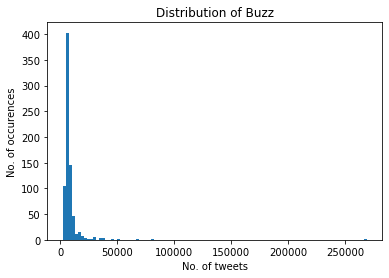

In [53]:
import matplotlib.pyplot as plt

# Preprocess variables
df['buzz'] = df['retweets'] + df['favorites']  # define buzz to be the simple sum of retweets and favorites
plt.hist(df['buzz'], bins=100)
plt.title('Distribution of Buzz')
plt.ylabel('No. of occurences')
plt.xlabel('No. of tweets')
plt.show()

# assume buzz follows gaussian distribution -> standardisation to mean=0, stdev=1
df['buzz'] = (df['buzz']-df['buzz'].mean())/df['buzz'].std()  

# df['sent_wn'] = df['buzz'] * df['finBERT']
# df['sent_wn'] = (df['sent_wn']-df['sent_wn'].min())/(df['sent_wn'].max()-df['sent_wn'].min())  # normalisation of sentiments

# The 12- and 26-day exponential moving averages (EMAs) are often the most popularly quoted or analyzed short-term averages
spy_data['EMA12'] = spy_data['adjclose'].ewm(span=12,adjust=False).mean()
spy_data['EMA26'] = spy_data['adjclose'].ewm(span=26,adjust=False).mean()
df['sent12'] = df['finBERT'].ewm(span=12,adjust=False).mean()  # also perform EMA on sentiments to smoothen noise
df['sent26'] = df['finBERT'].ewm(span=200,adjust=False).mean()  # also perform EMA on sentiments to smoothen noise

In [54]:
print('len sentiments:', len(df), '\nlen stock data:', len(spy_data))
print('Length of df and spy_data are different, because trading days do not include weekends and holidays!')
# print('We will combine them, taking the union, and then fill in the missing adjclose with the last value')
print('We will combine them by taking the intersection ie only trading days')
# spy_data.info()

# We will combine them, taking the union, and then fill in the missing adjClose with the last value
# data = df.merge(spy_data, left_index=True, right_index=True, how='outer')
data = df.merge(spy_data, left_index=True, right_index=True, how='inner')
data['adjclose'] = data['adjclose'].fillna(method='ffill')
data['EMA12'] = data['EMA12'].fillna(method='ffill')
data['EMA26'] = data['EMA26'].fillna(method='ffill')
print('len combined data:', len(data))

# save as csv
daily_fullpath = '../data/twitter/' + username + '_sentiments_overall_daily.csv'
data.to_csv(daily_fullpath, index_label='date')

# print(comb_data.isnull().sum())
data[0:30]

len sentiments: 756 
len stock data: 521
Length of df and spy_data are different, because trading days do not include weekends and holidays!
We will combine them by taking the intersection ie only trading days
len combined data: 521


FileNotFoundError: [Errno 2] No such file or directory: '../data/twitter/cnbc_sentiments_overall_daily.csv'

In [55]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, specs=[[{"secondary_y": True}], [{"secondary_y": False}]])
fig.add_trace(go.Scatter(x=data.index, y=data['finBERT'], opacity=0.2, name='sent'), secondary_y=True)
fig.add_trace(go.Scatter(x=data.index, y=data['sent12'], opacity=0.8, name='sent12'), secondary_y=True)
fig.add_trace(go.Scatter(x=data.index, y=data['sent26'], opacity=0.8, name='sent26'), secondary_y=True)
# fig.add_trace(go.Scatter(x=data.index, y=data['sent_min'], opacity=0.2, name='sent (min)'), secondary_y=True)
# fig.add_trace(go.Scatter(x=data.index, y=data['sent_max'], opacity=0.2, name='sent (max)'), secondary_y=True)

fig.add_trace(go.Scatter(x=data.index, y=data['adjclose'], opacity=0.2, name='SPY'), secondary_y=False)
fig.add_trace(go.Scatter(x=data.index, y=data['EMA12'], opacity=0.8, name='SPY12'), secondary_y=False)

fig.add_trace(go.Scatter(x=data.index, y=data['buzz'], opacity=0.8, name='buzz'), secondary_y=False, row=2, col=1)
# fig.add_trace(go.Scatter(x=data.index, y=data['ret12'], opacity=0.8, name='ret12'), secondary_y=False, row=2, col=1)
# fig.add_trace(go.Scatter(x=data.index, y=data["mom"], opacity=0.8, name='mom'), secondary_y=False, row=2, col=1)
# fig.add_trace(go.Scatter(x=data.index, y=data["signal"], opacity=0.8, name='signal'), secondary_y=False, row=2, col=1)

## Create machine learning models to attempt to predict market
Let's try to use N days of features and use it to predict the average direction of the market for the following day

In [56]:
SEQ_LEN = 7 # how far back do you want to go for prediction

#Define function to convert dataframe to training, validating and testing examples
def series_to_lstm(df, seq = SEQ_LEN):
    n_vars = df.shape[1]
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(0, seq):
        cols.append(df.shift(-i))
        names += [(df.columns[j]+ str(i)) for j in range(n_vars)]
       # print (df.head(5))
        # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    return agg

# Simple momentum calculation  
def get_mom(x, n1, n2):  
    if x[n1] > 0 and x[n2] > 0:
        return 1
    else:
        return 0

338 183


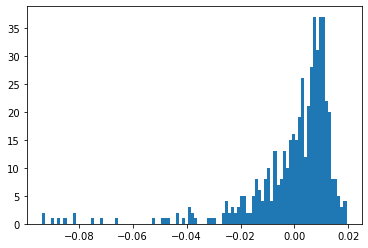

In [76]:
# Calculate returns based on EMA12's prices
data["ret12"] = data['EMA12'].pct_change(5)  # percent change over 5 days
data["ret12_lag1"] = data["ret12"].shift(1)
ret12_mean = data["ret12"].mean()
ret12_std = data["ret12"].std()

plt.hist(data['ret12'], bins=100)

# Calculate momentum
data["mom"] = data[['ret12', 'ret12_lag1']].apply(lambda x: get_mom(x, 'ret12', 'ret12_lag1'), axis=1)

# Calculate trading signal
# data["ret12_h"] = -data["ret12"].pct_change(-1)  # 1 day ahead
# data["signal"] = data["ret12_h"].apply(lambda x : 1 if x > 0 else 0 )
# data["signal"] = data["ret12_h"].apply(lambda x : 1 if x > 0 else 0 )

# Our prediction will be the next "num_days"'s returns. If it is positive relative to the day before, then we denote as 1, else 0
num_days = 5

# data["signal"] = data["ret12"].shift(-1).fillna(0).apply(lambda x : 1 if x > 0 else 0 )
# data["signal"] = (data["ret12"] - ret12_mean) / ret12_std  # normalise mean=0, std=1
# data["signal"] = data["signal"].shift(-num_days).fillna(0).apply(lambda x : 1 if x > 0 else 0 )
data["signal"] = -data['EMA12'].pct_change(-num_days)
data["signal"] = data["signal"].apply(lambda x : 1 if x > 0 else 0)



print(data[data["signal"]==1]["signal"].count(), data[data["signal"]==0]["signal"].count())


### Sentiment-enhanced LSTM Model (to delete)

In [85]:
data.head()

,retweets,favorites,finBERT,finBERT_min,finBERT_max,buzz,sent12,sent26,adjclose,volume,EMA12,EMA26,ret12,ret12_lag1,mom,signal
2018-03-12,1201,2184,-0.044627,-0.950706,0.856566,-0.406596,-0.044627,-0.044627,266.680542,71924800,266.680542,266.680542,NaN,NaN,0,0
2018-03-13,2985,4294,-0.108730,-0.901304,0.883569,-0.061350,-0.054489,-0.045265,264.957031,91968900,266.415386,266.552875,NaN,NaN,0,0
2018-03-14,2729,4657,-0.071643,-0.912810,0.839234,-0.051863,-0.057128,-0.045527,263.597351,105895100,265.981843,266.333947,NaN,NaN,0,0
2018-03-15,2758,4190,-0.108219,-0.935617,0.899704,-0.090697,-0.064988,-0.046151,263.310150,83433000,265.570813,266.109962,NaN,NaN,0,0
2018-03-16,2818,4099,-0.043349,-0.892756,0.897883,-0.093445,-0.061659,-0.046123,263.595703,100343700,265.266950,265.923721,NaN,NaN,0,0


In [78]:
# We will use buzz, EMA sentiments, EMA returns and momentum for our model, and compare with just using ret12 and momentum
features = data[["ret12", "mom"]]
features_sent = data[["buzz", "sent12", "ret12", "mom"]]

# Remove first few NA values, otherwise binary loss later cannot be calculated (nan)
print(features.isnull().sum())
print(features[:20])

s = 7
lstm_features = series_to_lstm(features[s:], SEQ_LEN)
lstm_features_sent = series_to_lstm(features_sent[s:], SEQ_LEN)
# traindata = {"features" : lstm_features, "signal" : data["signal"]}
traindata = {"features" : lstm_features, "features_sent": lstm_features_sent, "signal" : data["signal"][s:]}

ret12    5
mom      0
dtype: int64
               ret12  mom
2018-03-12       NaN    0
2018-03-13       NaN    0
2018-03-14       NaN    0
2018-03-15       NaN    0
2018-03-16       NaN    0
2018-03-19 -0.008322    0
2018-03-20 -0.009639    0
2018-03-21 -0.010267    0
2018-03-22 -0.014400    0
2018-03-23 -0.021202    0
2018-03-26 -0.021004    0
2018-03-27 -0.023615    0
2018-03-28 -0.025983    0
2018-03-29 -0.022406    0
2018-04-02 -0.019443    0
2018-04-03 -0.018977    0
2018-04-04 -0.014439    0
2018-04-05 -0.008924    0
2018-04-06 -0.009549    0
2018-04-09 -0.006070    0


In [87]:
import tensorflow.keras
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, Activation, LSTM, BatchNormalization
from tensorflow.keras.layers import Input, RepeatVector, Lambda, Flatten, multiply, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint   # bug
# from alt_model_checkpoint.tensorflow import AltModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# LSTM Model definition
def lstm_model(train_x, train_y, n_batch, epochs=20, class_weight=None):
    # Define LSTM model
    units = 8
    inputs = Input(shape=(train_x.shape[1], train_x.shape[2]))
    activations = LSTM(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,)(inputs)
    activations = BatchNormalization()(activations)
    x = Dropout(0.1)(activations)  # useful for over-fitting
    x = activations

    attention1 = Dense(1, activation='relu')(x)
#     attention2 = Flatten()(attention1)
    attention3 = Activation('softmax')(attention1)
    sent_representation = multiply([activations, attention3])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units,))(sent_representation)

    probabilities = Dense(1, activation='sigmoid')(sent_representation)
        
    model = Model(inputs=inputs, outputs=probabilities)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fit model (ignore below)
  #  checkpoint = ModelCheckpoint("lstm_stk.h5", monitor='val_binary_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
  #  early = EarlyStopping(monitor='binary_accuracy', min_delta=0, patience=4, verbose=0, mode='auto')
    
    history = model.fit(train_x, train_y, epochs=epochs,  batch_size=n_batch, 
                        #callbacks=[checkpoint, early],
                       # validation_data=(test_x, test_y), shuffle=False, verbose =  1)
                        shuffle=False, verbose = 0, class_weight= class_weight)
    
    return model


def train(x, y, train_split, n_batch, model_name, epochs=20):
    
    FEATURES_SHAPE = int(x.shape[1]/SEQ_LEN)
    X_SHAPE1 = SEQ_LEN
    X_SHAPE2 = FEATURES_SHAPE
    
    
    train_x , test_x, train_y, test_y = train_test_split(x, y , test_size=train_split, shuffle = False)

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_x = scaler.fit_transform(train_x)    
    train_x = train_x.reshape(train_x.shape[0], X_SHAPE1, X_SHAPE2)  # time series length
    train_y = train_y.values.reshape((train_y.shape[0], 1))

    test_x = scaler.fit_transform(test_x)
    test_x = test_x.reshape(test_x.shape[0], X_SHAPE1, X_SHAPE2) 
    test_y = test_y.values.reshape((test_y.shape[0], 1))

    #Check train_y statistic
    trainStats = np.unique(train_y, return_counts=True)
    # print(trainStats)

    #Compute class weight for model
    classweight = class_weight.compute_class_weight('balanced', np.unique(train_y), train_y.flatten())

    model= lstm_model(train_x, train_y, n_batch, epochs=epochs, class_weight=classweight)
    model.save(model_name)

    # in-sample accuracy
    print(model.metrics_names)
    train_score = model.evaluate(train_x, train_y)
    print ("Prediction In-sample accuracy for market: " + str(train_score[1]))
    test_score = model.evaluate(test_x, test_y)
    print ("Prediction out-of-sample accuracy for market: " + str(test_score[1]))
    
    accuracy = [train_score[1],test_score[1]]
    print(accuracy)
    return model, test_x, test_y

In [89]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

accuracy = {}
train_split = 0.2
n_batch = 4  ## Batch Size

m1, x_test, y_test = train(traindata["features"], traindata["signal"], train_split, n_batch, "lstm_stk_SPY.h5", epochs=30)
# m1.predict(traindata["features"])

y_pred1 = m1.predict(x_test)
y_pred = np.argmax(y_pred1, axis=1)
print(classification_report(y_test, y_pred))
# print(precision_score(y_test, y_pred))
# print(recall_score(y_test, y_pred))
# print(f1_score(y_test, y_pred))


['loss', 'binary_accuracy']
411/411 [==============================] - 0s 983us/sample - loss: 0.3726 - binary_accuracy: 0.9002
Prediction In-sample accuracy for market: 0.9002433
103/103 [==============================] - 0s 117us/sample - loss: nan - binary_accuracy: 0.9320
Prediction out-of-sample accuracy for market: 0.93203884
[0.9002433, 0.93203884]
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        36
           1       0.00      0.00      0.00        67

    accuracy                           0.35       103
   macro avg       0.17      0.50      0.26       103
weighted avg       0.12      0.35      0.18       103



In [86]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

FEATURES_SHAPE = int(traindata['features'].shape[1]/SEQ_LEN)
X_SHAPE1 = SEQ_LEN
X_SHAPE2 = FEATURES_SHAPE

# traindata["features"].shape
scaler = MinMaxScaler(feature_range=(0, 1))
all_x = scaler.fit_transform(traindata["features"])    
all_x = all_x.reshape(all_x.shape[0], X_SHAPE1, X_SHAPE2)  # time series length

y_pred1 = m1.predict(all_x)
y_pred = np.argmax(y_pred1, axis=1)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

In [83]:
accuracy = {}
train_split = 0.2
n_batch = 4  ## Batch Size

m2 = train(traindata["features_sent"], traindata["signal"], train_split, n_batch, "lstm_stk_SPY_sent.h5", epochs=30)

['loss', 'binary_accuracy']
411/411 [==============================] - 0s 854us/sample - loss: 0.4077 - binary_accuracy: 0.9757
Prediction In-sample accuracy for market: 0.9756691
103/103 [==============================] - 0s 126us/sample - loss: nan - binary_accuracy: 0.9806
Prediction out-of-sample accuracy for market: 0.98058254
[0.9756691, 0.98058254]


### Sentiment-enhanced LSTM Model

In [45]:
import os
import sys
sys.path.append('../models/lstm_nn')  # add parent folder to sys path
if 'lstm_nn' not in os.getcwd(): os.chdir('../models/lstm_nn')

import json
import math
import matplotlib.pyplot as plt
from core.data_processor import DataLoader
from core.model import Model

toTrain = True

# get LSTM configuration details from config.json
configs = json.load(open('config.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

# configs['data']['filename'] = 'LiveSquawk_sentiments_overall_daily.csv'
# configs['data']['columns'] = ['EMA12', 'sent', 'sent_min', 'volume']
configs['data']['filename'] = 'cnbc_sentiments_overall_daily.csv'
configs['data']['columns'] = ['EMA12', 'sent12', 'buzz', 'volume']
configs['data']['sequence_length'] = 14
configs['model']['layers'][0]['input_timesteps'] = configs['data']['sequence_length'] - 1
configs['model']['layers'][0]['input_dim'] = len(configs['data']['columns'])

configs['training']['epochs'] = 4
    
    
data = DataLoader(
    os.path.join('data', configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns']
)

# train model
if toTrain:
    import numpy as np
    import tensorflow as tf
    np.random.seed(10)
    tf.compat.v1.set_random_seed(1)
    
    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
    # in-memory training
    model.train(
        x,
        y,
        epochs = configs['training']['epochs'],
        batch_size = configs['training']['batch_size'],
        save_dir = configs['model']['save_dir']
    )
    '''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )
    
    model_use = model

else:
    # Get predictions
    import glob
    list_of_files = glob.glob(configs['model']['save_dir'] + '/*h5') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)

    model_use = Model()
    model_use.load_model(latest_file)    

    
x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)
    

[Model] Model Compiled
Time taken: 0:00:00.668003
[Model] Training Started
[Model] 4 epochs, 32 batch size, 14 batches per epoch
Epoch 1/4
14/14 [==============================] - 5s 356ms/step - loss: 0.0025
Epoch 2/4
14/14 [==============================] - 1s 54ms/step - loss: 0.0013
Epoch 3/4
14/14 [==============================] - 1s 48ms/step - loss: 9.0244e-04
Epoch 4/4
14/14 [==============================] - 1s 61ms/step - loss: 7.2196e-04
[Model] Training Completed. Model saved as saved_models\06042020-170525-e4.h5
Time taken: 0:00:07.263966


[Model] Predicting Point-by-Point...


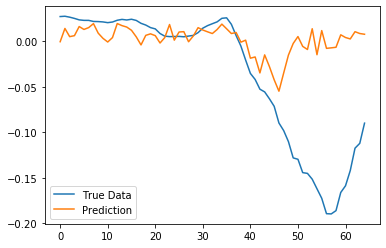

[Model] Predicting Sequences Multiple...


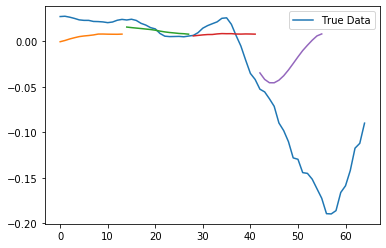

In [46]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.legend()
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
    #plt.ylim(top=5, bottom=-5)    
    plt.show()
    
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()    

predictions = model_use.predict_point_by_point(x_test)
plot_results(predictions, y_test)
    
predictions_seq = model_use.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
plot_results_multiple(predictions_seq, y_test, configs['data']['sequence_length'])

In [47]:
x_test[0:10]

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 2.10606106e-03, -7.75394698e-01, -1.27642852e-01,
          8.04065575e-01],
        [ 3.98155886e-03, -1.48475449e+00,  1.07043936e+00,
          5.25458973e-01],
        [ 6.64053970e-03, -1.72586911e+00, -6.11805392e-02,
          5.48775854e-01],
        [ 8.92488207e-03, -9.56922947e-01,  1.13117975e-01,
          1.43528527e-01],
        [ 1.08676172e-02, -8.30166151e-01, -1.92564647e+00,
         -9.91238857e-02],
        [ 1.31556718e-02, -7.92755956e-01,  5.60748251e-01,
          5.96704792e-01],
        [ 1.57835681e-02, -7.04187725e-01, -1.39086693e-01,
          1.75396928e+00],
        [ 1.82493287e-02, -5.45187513e-01, -7.94466714e-01,
         -8.21836789e-03],
        [ 2.03406868e-02, -9.83535842e-01,  1.12105635e+00,
         -6.20618726e-01],
        [ 2.29553326e-02, -6.43863066e-01,  2.02908119e-01,
         -4.21453852e-01],
        [ 2.51281775e-02, -1.86568618e-01, 